# Sentiment Analysis on Movie Reviews
This dataset contains two columns: review and sentiment. The review column includes text data **(movie reviews)**, and the sentiment column labels each review as either `"positive"` or `"negative."` The main aim is to develop a model that can predict positive or negative reviews of different movie sentiments.

## Import Libraries
Import all necessary libraries to be used in the analysis process.

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import ne_chunk, pos_tag
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import preprocessing

# Download necessary NLTK resources

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marke\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marke\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\marke\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\marke\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\marke\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

### Load the dataset
Load the dataset and display the first few rows of the datatset.

In [4]:
movie_df = pd.read_csv('C:/Users/marke/Downloads/IMDB Dataset.csv')

In [6]:
movie_df.head(30)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


## Quick overview of the data

In [8]:
print(movie_df.isnull().sum())

review       0
sentiment    0
dtype: int64


In [10]:
movie_df.dtypes

review       object
sentiment    object
dtype: object

# Visualize the Distribution of Reviews (Positive vs. Negative)
This step visualizes how many reviews are positive and how many are negative.

The reviews are equal which means our dataset will not be biased.

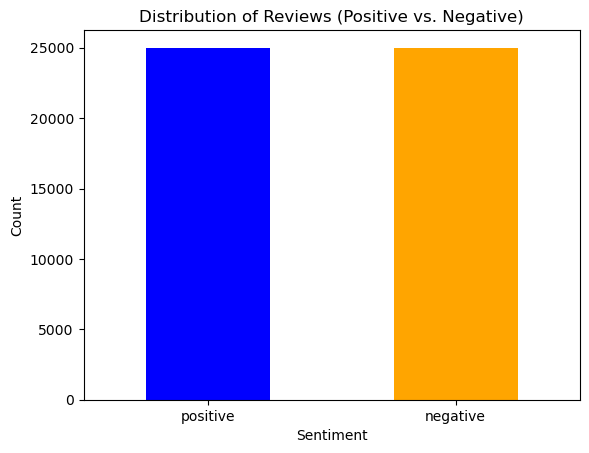

In [12]:
movie_df['sentiment'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Distribution of Reviews (Positive vs. Negative)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Step 1: Text Preprocessing

### Remove named entities (NER)
Named entities(e.g., names of people, places) which may not contribute to meaningful classification are removed.

In [14]:
# Function to remove named entities
def remove_named_entities(text):
    # Tokenization and Part-of-Speech tagging
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)

    # Named Entity Recognition
    named_entities = ne_chunk(pos_tags)

    # Remove named entities by skipping chunks that represent entities
    cleaned_tokens = []
    for chunk in named_entities:
        if isinstance(chunk, nltk.Tree):  # If it's a named entity
            entity_label = chunk.label()
            if entity_label not in ['PERSON', 'ORGANIZATION', 'GPE']:  # Skip these entity types
                # If it's not a target entity, add the tokens back
                cleaned_tokens.extend([token for token, pos in chunk.leaves()])
        else:
            # If it's not a named entity, add the token back
            token, pos = chunk
            cleaned_tokens.append(token)

    # Join tokens back into a string
    return ' '.join(cleaned_tokens)

# Apply the function to the DataFrame
movie_df['cleaned_review'] = movie_df['review'].apply(remove_named_entities)

# Display the results
movie_df.head(5)


,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,A wonderful little production . < br / > < br ...
2,I thought this was a wonderful way to spend ti...,positive,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,Basically there 's a family where a little boy...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,'s `` Love in the Time of '' is a visually stu...


### Convert all text to lowercase

This ensures that all text is uniform (e.g., "Great" and "great" are treated the same).

In [16]:
movie_df['cleaned_review'] = movie_df['cleaned_review'].str.lower()

In [18]:
movie_df.head(5)

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production . < br / > < br ...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there 's a family where a little boy...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,'s `` love in the time of '' is a visually stu...


## Remove HTML tags from text in the dataset

This ensures that the dataset does not have any HTML Markup that might interfere with analysis

In [20]:
from bs4 import BeautifulSoup
import re

def remove_html(text):
    if isinstance(text, str):
        try:
            # Remove HTML using BeautifulSoup
            clean_text = BeautifulSoup(text, "html.parser").get_text()

            # Remove standalone "br" from the text
            clean_text = re.sub(r'\bbr\b', '', clean_text)

            # Remove any unwanted characters (like remaining HTML artifacts) using regex
            clean_text = re.sub(r'\s+', ' ', clean_text)  # Remove excessive whitespace
            clean_text = re.sub(r'[^\w\s]', '', clean_text)  # Remove punctuation except word characters and spaces

            # Remove extra spaces left after removing "br"
            clean_text = re.sub(r'\s+', ' ', clean_text).strip()

            return clean_text.lower()  # Convert to lowercase
        except Exception as e:
            print(f"Error processing text: {e}")
            return text
    return text

# Apply the function to the 'cleaned_review' column
movie_df['cleaned_review'] = movie_df['cleaned_review'].apply(remove_html)

# Display the first few rows to verify changes
movie_df.head(5)

C:\Users\marke\AppData\Local\Temp\ipykernel_18284\309602770.py:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_text = BeautifulSoup(text, "html.parser").get_text()


,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there s a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,s love in the time of is a visually stunning f...


### Remove URLs, measurements, numbers, filler words, special characters, and punctuation

### Remove URLs
URLs are not useful for sentiment analysis thus removing them ensures the dataset is cleaner

In [22]:
def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

movie_df['cleaned_review'] = movie_df['cleaned_review'].apply(remove_urls)
movie_df.head(5)

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there s a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,s love in the time of is a visually stunning f...


### Remove both numerical and written numbers

This ensures that the numbers do not interfere with the text-based analysis.

In [24]:
def remove_numbers(text):
    text = re.sub(r'\b\d+\b', '', text)  # Remove numerical digits
    text = re.sub(r'\b(one|two|three|four|five|six|seven|eight|nine|ten)\b', '', text)  # Remove written numbers
    return text

movie_df['cleaned_review'] = movie_df['cleaned_review'].apply(remove_numbers)
movie_df.head(5)

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,of the other reviewers has mentioned that aft...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there s a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,s love in the time of is a visually stunning f...


### Remove measurements
Irrelevant units of measurements that do not contribute to sentiment classification are removed.

In [26]:
def remove_measurements(text):
    # Regular expression to match measurements (e.g., numbers followed by units)
    # Example units: kg, meters, cm, lb, g, etc.
    pattern = r'\b\d+\.?\d*\s?(kg|cm|meter|meters|mm|g|lb|oz|km|miles|inch|inches|feet|ft)\b'

    # Remove all measurements from the text
    cleaned_text = re.sub(pattern, '', text, flags=re.IGNORECASE)

    return cleaned_text

movie_df['cleaned_review'] = movie_df['cleaned_review'].apply(remove_measurements)
movie_df.head(5)

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,of the other reviewers has mentioned that aft...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there s a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,s love in the time of is a visually stunning f...


### **Remove Emojis**
This ensures that reviews do not contain emojis or smileys that could interfere with accurate text processing and analysis.

In [28]:
!pip install emoji

In [30]:
import emoji

def remove_emojis(text):
    return emoji.replace_emoji(text, replace='')

movie_df['cleaned_review'] = movie_df['cleaned_review'].apply(remove_emojis)
movie_df.head(5)


,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,of the other reviewers has mentioned that aft...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically there s a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,s love in the time of is a visually stunning f...


### **Remove Filler Words**

Filler words like "um", "you know", "actually", etc., do not contribute meaningful content to the text. They serve more as conversation fillers or verbal pauses in speech, and when included in text data, they dilute the clarity and focus of the content.

In [32]:
# Define a list of filler words to remove
filler_words = [
    "uh", "um", "er", "probably", "you know", "I mean", "well", "so", "like", "basically",
    "actually", "seriously", "really", "just", "sort of", "kind of", "whatever",
    "honestly", "literally", "right", "yeah", "okay", "alright"
]

# Create a regex pattern from the list of filler words
filler_pattern = r'\b(?:' + '|'.join(filler_words) + r')\b'

# Define a function to remove filler words
def remove_filler_words(text):
    # Substitute filler words with an empty string
    cleaned_text = re.sub(filler_pattern, '', text, flags=re.IGNORECASE)
    # Remove extra spaces left after removing filler words
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

# Apply the function to the text data
movie_df['cleaned_review'] = movie_df['cleaned_review'].apply(remove_filler_words)

# Show the original and cleaned reviews
movie_df.head(5)

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,of the other reviewers has mentioned that afte...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,there s a family where a little boy thinks the...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,s love in the time of is a visually stunning f...


## Remove special characters and punctuation

Special characters and punctuation can vary in usage between different reviews, even if the content is similar. By removing punctuation, the text becomes more uniform and easier to analyze.

### Remove punctuation

In [34]:
import string

def remove_special_chars(text):
    # Remove all punctuation and special characters except letters and numbers
    return re.sub(r'[{}]'.format(re.escape(string.punctuation)), '', text)

# Apply the function to the review column
movie_df['cleaned_review'] = movie_df['cleaned_review'].apply(remove_special_chars)
movie_df.head(5)


,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,of the other reviewers has mentioned that afte...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,there s a family where a little boy thinks the...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,s love in the time of is a visually stunning f...


### Remove special characters

In [36]:
import re

def remove_special_chars(text):
    # Remove all characters that are not letters, numbers, or spaces
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

# Apply the function to the review column
movie_df['cleaned_review'] = movie_df['cleaned_review'].apply(remove_special_chars)
movie_df.head(5)

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,of the other reviewers has mentioned that afte...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,there s a family where a little boy thinks the...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,s love in the time of is a visually stunning f...


### Tokenization and Removal of Stop Words

This aims to split each review into individual words or tokens, which serve as the foundation for further text analysis.Removing the stopwords such as "the" are removed wwhich are not helpful for classification.

In [38]:
def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    additional_stop_words = [
    'movie', 'film', 'one', 'like', 'story', 'character', 'characters', 'just',
    'time', 'really', 'get', 'good', 'much', 'even', 'make', 'way', 'well',
    'first', 'see', 'two', 'also', 'would', 'could', 'many', 'people'
]
    stop_words = stop_words.union(set(additional_stop_words))
    clean_text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    return clean_text
movie_df['cleaned_review'] = movie_df['cleaned_review'].apply(remove_stop_words)

def tokenize_text(text):
    return word_tokenize(text)
movie_df['tokens'] = movie_df['cleaned_review'].apply(tokenize_text)
movie_df.head()

,review,sentiment,cleaned_review,tokens
0,One of the other reviewers has mentioned that ...,positive,reviewers mentioned watching oz episode hooked...,"[reviewers, mentioned, watching, oz, episode, ..."
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...,"[wonderful, little, production, filming, techn..."
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful spend hot summer weekend sit...,"[thought, wonderful, spend, hot, summer, weeke..."
3,Basically there's a family where a little boy ...,negative,family little boy thinks zombie closet parents...,"[family, little, boy, thinks, zombie, closet, ..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,love visually stunning watch offers us vivid p...,"[love, visually, stunning, watch, offers, us, ..."


### Add Custom Stopwords

In [40]:
# Define custom stopwords for positive and negative reviews
positive_stopwords = ["amazing", "great", "excellent", "best", "wonderful", "awesome", "fantastic", "brilliant"]
negative_stopwords = ["terrible", "horrible", "awful", "worst", "bad", "boring", "disappointing", "poor"]

In [42]:
import nltk
from nltk.corpus import stopwords

# Download stopwords from NLTK if necessary
nltk.download('stopwords')

# Get NLTK's standard English stopwords
nltk_stopwords = set(stopwords.words('english'))

# Combine NLTK stopwords with custom stopwords for good and bad reviews
positive_all_stopwords = nltk_stopwords.union(positive_stopwords)
negative_all_stopwords = nltk_stopwords.union(negative_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marke\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
# Define a function to remove links
def remove_links(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text)

# Define a function to remove stopwords based on sentiment
def remove_sentiment_stopwords(text, sentiment):
    words = text.split()
    if sentiment == 'positive':
        cleaned_text = ' '.join([word for word in words if word.lower() not in positive_all_stopwords])
    elif sentiment == 'negative':
        cleaned_text = ' '.join([word for word in words if word.lower() not in negative_all_stopwords])
    else:
        cleaned_text = text  # In case there is no sentiment label
    return cleaned_text


# Apply the cleaning functions (based on sentiment)
movie_df['review'] = movie_df.apply(lambda row: remove_sentiment_stopwords(remove_links(row['review']), row['sentiment']), axis=1)

# Show the cleaned reviews
movie_df[['review', 'cleaned_review', 'sentiment']].head()

,review,cleaned_review,sentiment
0,One reviewers mentioned watching 1 Oz episode ...,reviewers mentioned watching oz episode hooked...,positive
1,little production. <br /><br />The filming tec...,wonderful little production filming technique ...,positive
2,"thought way spend time hot summer weekend, sit...",thought wonderful spend hot summer weekend sit...,positive
3,Basically there's family little boy (Jake) thi...,family little boy thinks zombie closet parents...,negative
4,"Petter Mattei's ""Love Time Money"" visually stu...",love visually stunning watch offers us vivid p...,positive


### Stemming

This ensures that words are reduced to their basic form making it easier to group similar words with the same meaning

In [46]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

movie_df['tokens'] = movie_df['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

# Display the cleaned tokens
movie_df[['review', 'tokens']].head()

,review,tokens
0,One reviewers mentioned watching 1 Oz episode ...,"[review, mention, watch, oz, episod, hook, exa..."
1,little production. <br /><br />The filming tec...,"[wonder, littl, product, film, techniqu, unass..."
2,"thought way spend time hot summer weekend, sit...","[thought, wonder, spend, hot, summer, weekend,..."
3,Basically there's family little boy (Jake) thi...,"[famili, littl, boy, think, zombi, closet, par..."
4,"Petter Mattei's ""Love Time Money"" visually stu...","[love, visual, stun, watch, offer, us, vivid, ..."


In [48]:
movie_df.head(30)

,review,sentiment,cleaned_review,tokens
0,One reviewers mentioned watching 1 Oz episode ...,positive,reviewers mentioned watching oz episode hooked...,"[review, mention, watch, oz, episod, hook, exa..."
1,little production. <br /><br />The filming tec...,positive,wonderful little production filming technique ...,"[wonder, littl, product, film, techniqu, unass..."
2,"thought way spend time hot summer weekend, sit...",positive,thought wonderful spend hot summer weekend sit...,"[thought, wonder, spend, hot, summer, weekend,..."
3,Basically there's family little boy (Jake) thi...,negative,family little boy thinks zombie closet parents...,"[famili, littl, boy, think, zombi, closet, par..."
4,"Petter Mattei's ""Love Time Money"" visually stu...",positive,love visually stunning watch offers us vivid p...,"[love, visual, stun, watch, offer, us, vivid, ..."
5,"Probably all-time favorite movie, story selfle...",positive,alltime favorite selflessness sacrifice dedica...,"[alltim, favorit, selfless, sacrific, dedic, n..."
6,sure would like see resurrection dated Seahunt...,positive,sure resurrection dated seahunt series tech to...,"[sure, resurrect, date, seahunt, seri, tech, t..."
7,"show amazing, fresh & innovative idea 70's fir...",negative,show amazing fresh innovative idea aired years...,"[show, amaz, fresh, innov, idea, air, year, br..."
8,Encouraged positive comments film looking forw...,negative,encouraged positive comments looking forward w...,"[encourag, posit, comment, look, forward, watc..."
9,like original gut wrenching laughter like movi...,positive,original gut wrenching laughter young old love...,"[origin, gut, wrench, laughter, young, old, lo..."


<!-- #### Remove numbers -->

## Vectorization

### Convert Text into Numerical Format(TF-IDF vectorizer)
The conversion of text to numerical matrix to be used in the ML algorithms.

In [50]:
# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the reviews into a sparse matrix
tfidf_matrix = vectorizer.fit_transform(movie_df['cleaned_review'])

# Get feature names (words in the vocabulary)
feature_names = vectorizer.get_feature_names_out()

# Example: Get the TF-IDF scores for the first review
first_review_scores = tfidf_matrix[0]

# Convert the sparse matrix for the first review to a dictionary
# Using first_review_scores.toarray() would cause MemoryError, so we avoid that
importance_scores = {feature_names[i]: first_review_scores[0, i] for i in first_review_scores.nonzero()[1]}

# Print the TF-IDF scores for the first review
print(importance_scores)

{'darker': 0.08094408176552509, 'touch': 0.06313992741060499, 'thats': 0.0673903502953021, 'viewing': 0.05718400891938917, 'uncomfortable': 0.07780635342211147, 'comfortable': 0.07971461668802302, 'experience': 0.05262617223662395, 'skills': 0.07063316867165077, 'street': 0.06203016796949223, 'lack': 0.05318075384366576, 'bitches': 0.11032856249515557, 'turned': 0.054611971590473776, 'class': 0.058568783303569544, 'middle': 0.057330471692430454, 'mannered': 0.09667184050989658, 'order': 0.05483595754327817, 'kill': 0.05314124888226667, 'inmates': 0.18554559952363328, 'nickel': 0.11961709809086447, 'sold': 0.07662156362740534, 'guards': 0.08691033379675006, 'crooked': 0.09200044679455097, 'injustice': 0.09141535602417104, 'graphic': 0.07208389889438584, 'levels': 0.07121017515519468, 'accustomed': 0.09667184050989658, 'got': 0.03869294289333197, 'taste': 0.06414963143685244, 'developed': 0.06587345683777336, 'watched': 0.043884237832812874, 'ready': 0.06674549212337658, 'surreal': 0.072

### Bag of Words(BoW)

The Bag of Words model is a way of representing text data where each unique word in the corpus is represented as a feature. The model doesn't consider grammar or word order, just the frequency of words in the text.

**Aim**: To convert the movie reviews into a numerical format by counting the frequency of words using the Bag of Words model.

In [52]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# Initialize CountVectorizer (BoW)
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the reviews to a BoW matrix (X)
X = vectorizer.fit_transform(movie_df['cleaned_review'])

# Define the target variable (y)
y = movie_df['sentiment']


### Word cloud
A Word Cloud visually represents the most frequent words in the text, where the size of each word indicates its frequency or importance.

**Aim**: To visualize the most frequent words in the movie reviews using a word cloud.

* CountVectorizer(): This function converts
the text into a bag of words model by counting the occurrences of each word.

* fit_transform(): This method is applied to fit the vectorizer on the text and transform it into a sparse matrix where each row corresponds to a document, and each column corresponds to a word.

* get_feature_names_out(): This retrieves the vocabulary (list of words) created by the vectorizer.

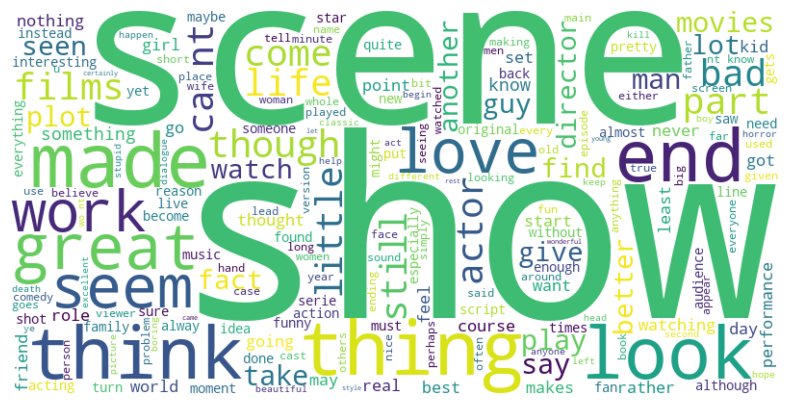

In [54]:
# pip install wordcloud matplotlib nltk pandas
# Import required libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all the cleaned reviews into one large text
all_text = ' '.join(movie_df['cleaned_review'].tolist())

# Create the word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axis to show
plt.show()

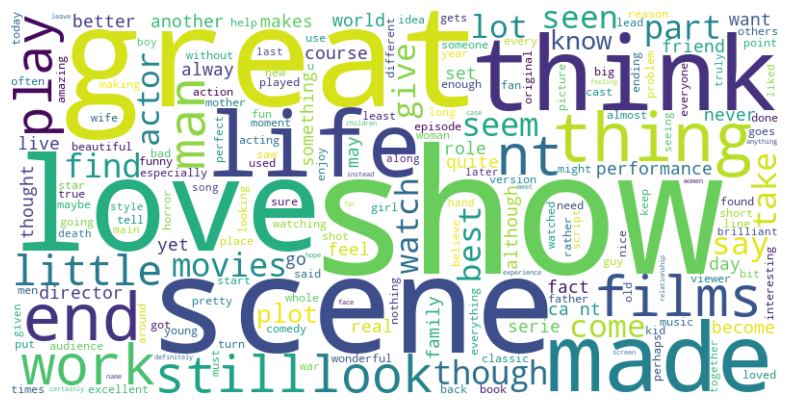

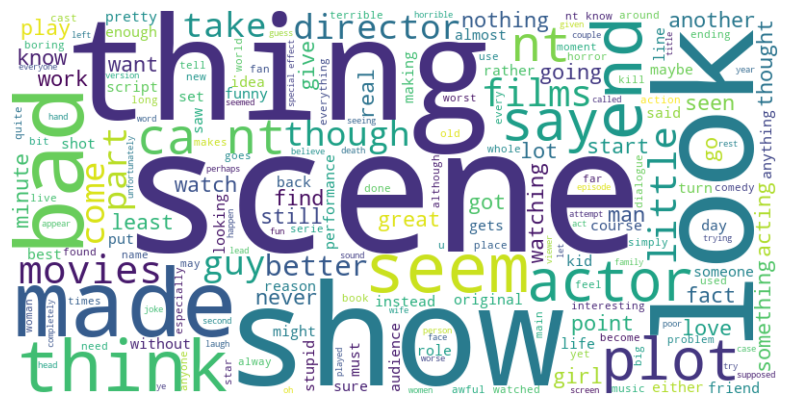

In [56]:
# Generate a word cloud for positive reviews
positive_reviews = ' '.join(movie_df[movie_df['sentiment'] == 'positive']['cleaned_review'].tolist())
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

# Plot the positive word cloud
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate a word cloud for negative reviews
negative_reviews = ' '.join(movie_df[movie_df['sentiment'] == 'negative']['cleaned_review'].tolist())
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

# Plot the negative word cloud
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Convert sentiment to numerical values (binary: 1 for positive, 0 for negative)

In [58]:
y = pd.get_dummies(movie_df['sentiment'], drop_first=True).values.ravel()  # Positive = 1, Negative = 0

## Training

### Train-test split

In [60]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Show the sizes of the training and testing sets
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (40000, 109850)
Testing set size: (10000, 109850)


### Naive Bayes
It is fast and efficient model for sentiment analysis, leveraging its strengths in handling high-dimensional text data and providing probabilistic outputs for classification.

In [62]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
print(f'Naive Bayes Accuracy: {accuracy_score(y_test, y_pred_nb)}')



Naive Bayes Accuracy: 0.8576


### Logistic Regression
Provides a baseline for classification tasks, especially when there is a linear relationship between features and the target.

In [64]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
print(f'Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_log)}')


Logistic Regression Accuracy: 0.8748


### Random Forest
Handles complex, non-linear relationships and provide a more robust model by averaging multiple decision trees, reducing overfitting.

In [66]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {rf_accuracy:.4f}')


Random Forest Accuracy: 0.8633


### Decision Tree
Creates an interpretable model that shows the importance of features and provides clear decision rules, but with a risk of overfitting on small datasets.

In [68]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
tree_accuracy = accuracy_score(y_test, y_pred_tree)
print(f'Decision Tree Accuracy: {tree_accuracy:.4f}')


Decision Tree Accuracy: 0.7340


### Confusion matrix for Naive Bayes

* True Positives (1 predicted as 1): 4,297
* True Negatives (0 predicted as 0): 4,279
* False Positives (0 predicted as 1): 682
* False Negatives (1 predicted as 0): 742

 - Naive Bayes has a relatively high number of false negatives compared to the other models, meaning it misclassifies many positive instances as negative


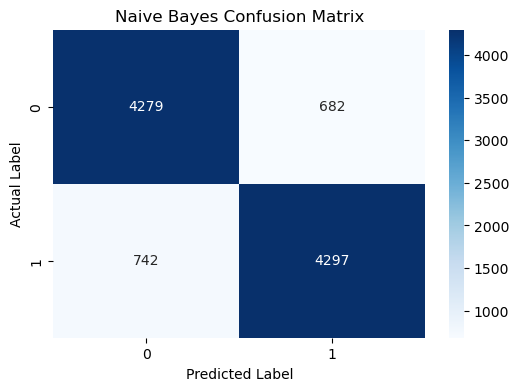

In [70]:
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues")
plt.title('Naive Bayes Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Confusion matrix for Logistic Regression

* True Positives: 4,425
* True Negatives: 4,319
* False Positives: 642
* False Negatives: 614

Logistic Regression has the fewest false negatives, meaning it performs slightly better in correctly identifying positive instances. The overall balance of correct predictions for both classes is better than Naive Bayes.

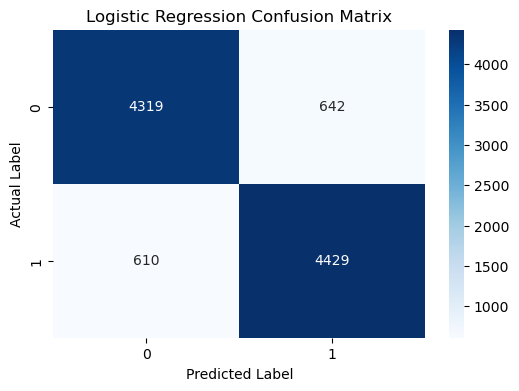

In [72]:
cm_log = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Blues")
plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Confusion matrix for Random Forest

* True Positives: 4,333
* True Negatives: 4,253
* False Positives: 708
* False Negatives: 706

Random Forest performs similarly to Logistic Regression but with slightly higher false positives and false negatives. However, it still has a good balance between positive and negative classifications.

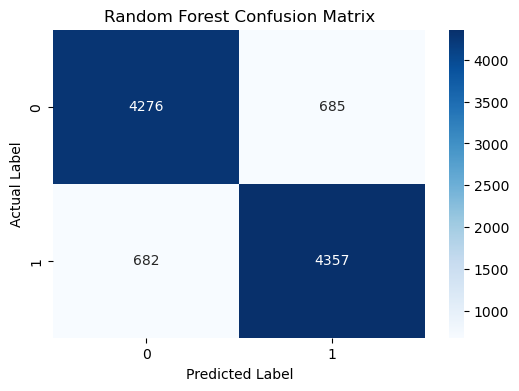

In [74]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.title('Random Forest Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Confusion matrix for Decision Tree

* True Positives (TP): 3,669
* True Negatives (TN): 3,682
* False Positives (FP): 1,279
* False Negatives (FN): 1,370

The Decision Tree classifier shows a fairly balanced performance between true positive and true negative classifications. However, it also has a noticeable number of false positives and false negatives. This could indicate that while the model captures both classes reasonably well, there is some room for improvement, particularly in reducing misclassifications.

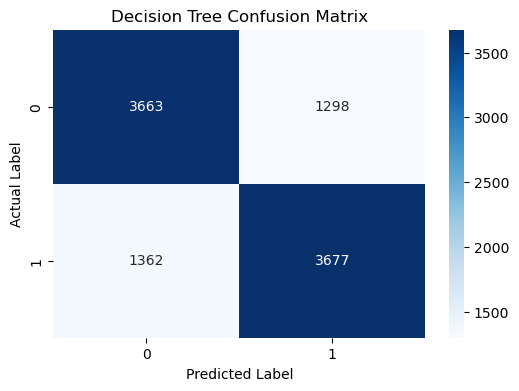

In [76]:
cm_tree = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_tree, annot=True, fmt="d", cmap="Blues")
plt.title('Decision Tree Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()



### Sentiment Classification Model Results

#### 1. Model Performance
- **Logistic Regression Accuracy**: 87.48%
- **Naive Bayes Accuracy**: 85.76%
- **Random Forest Accuracy**: 86.33%
- **Decision Tree Accuracy**: 73.40%

Logistic Regression achieved the best performance, with an accuracy of 88.27%, followed by Random Forest and Naive Bayes.

| Model              | Accuracy  |
|--------------------|-----------|
| Logistic Regression | 87.48%    |
| Naive Bayes         | 85.76%    |
| Random Forest       | 86.33%    |
| Decision Tree       | 73.40%    |

#### 2. Key Insights
- **Text Preprocessing**: Techniques such as cleaning text (removal of numbers, punctuation, and stop words) significantly improved the quality of the data.
- **TF-IDF Representation**: Helped highlight important words, minimizing the influence of frequently occurring, less meaningful terms.
- **Class Imbalance**: Slight class imbalance may have affected the performance of the Naive Bayes model.

#### 3. Challenges
- **Overfitting**: Certain models, particularly Decision Tree and Random Forest, showed signs of overfitting, which led to decreased generalization on unseen data.

#### 4. Conclusion
Logistic Regression provided the highest accuracy and demonstrated reliability for sentiment classification. Future improvements could involve hyperparameter tuning and feature engineering (such as incorporating bigrams or word embeddings) to boost model performance further.t model performance further.

# Create a Simple UI

Install the Required Libraries: First, install the required libraries for packaging and creating the UI.

#### Install Required Libraries

In [79]:
import joblib
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer


#### Function to Predict Sentiment
Create a function that will predict the sentiment based on the selected model and the user’s input:

In [81]:
def predict_sentiment(review, model_choice):
    # Transform the input review using the vectorizer
    review_vector = vectorizer.transform([review])
    
    # Predict based on the selected model
    if model_choice == "Logistic Regression":
        model = log_reg
    elif model_choice == "Naive Bayes":
        model = nb_model
    elif model_choice == "Random Forest":
        model = rf_model
    elif model_choice == "Decision Tree":
        model = tree_model

    # Make the prediction
    prediction = model.predict(review_vector)
    probability = model.predict_proba(review_vector)
    
    sentiment = "Positive" if prediction[0] == 1 else "Negative"
    confidence = np.max(probability)
    
    return sentiment, confidence


## Set Up the Models and Save Them:

Save the trained models using joblib or pickle to later load them in the UI.

In [83]:
import joblib

# Save models
joblib.dump(log_reg, 'logistic_regression_model.pkl')
joblib.dump(nb_model, 'naive_bayes_model.pkl')
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(tree_model, 'decision_tree_model.pkl')



['decision_tree_model.pkl']

In [85]:
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

#### Load the Pre-trained Models and TF-IDF Vectorizer

In [87]:
# Load the saved models
log_reg = joblib.load('logistic_regression_model.pkl')
nb_model = joblib.load('naive_bayes_model.pkl')
rf_model = joblib.load('random_forest_model.pkl')
tree_model = joblib.load('decision_tree_model.pkl')

# Load the TF-IDF vectorizer
vectorizer = joblib.load('tfidf_vectorizer.pkl')


In [89]:
pip install streamlit

## Create the Streamlit App:

This has been done on Visual Studio as app.py